In [136]:
from astropy.io import fits
from scipy import *
import numpy as np
from pylab import *
from astropy.coordinates import SkyCoord
import astropy.units as units
from IPython.display import Image

from astropy.coordinates import FK5, ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u

In [3]:
################ APOGESS DR14
## Number of objects: 277,371
hdulist = fits.open('allStar-l31c.2.fits')

In [4]:
################ GAIA DR2 matched to APOGEE DR14
## Number of objects: 284,395
## description: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html
## data_gaia = loadtxt('gaia_dr2_apogee_cross.dat')
## save('gaia_dr2_apogee_cross.npy', data_gaia)

data_gaia = load('gaia_dr2_apogee_cross.npy').T
cols_gaia = ['ra', 'ra_err', 'dec', 'dec_err', 'para', 'para_err', 'pmra', 'pmra_err', 
             'pmdec', 'pmdec_err', 'ra_dec_corr', 'ra_para_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
             'dec_para_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'para_pmra_corr', 'para_pmdec_corr', 
             'pmra_pmdec_corr', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
             'radial_velocity_error', 'j', 'j_err', 'h', 'h_err', 'k', 'k_err', 'teff', 'teff_err', 'vmacro']
gaia = lambda field: data_gaia[cols_gaia.index(field)]

In [5]:
print 'gaia data shape:',data_gaia.T.shape
print 'gaia catalogue fieds:',len(cols_gaia)
print 'gaia objects with no parallex:',sum(isnan(gaia('para')))

gaia data shape: (284394, 36)
gaia catalogue fieds: 36
gaia objects with no parallex: 9573


In [156]:
#ra_gaiaJ20155, dec_gaiaJ20155 = gaia('ra'), gaia('dec')
######### transform to J2000
### http://docs.astropy.org/en/stable/coordinates/index.html
### doesnt seem to work since they have different coordinate system?
### At GAIA DR2 this reference epoch is always J2015.5 
### https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

#coord_J20155 = SkyCoord(ra=ra_gaiaJ20155*u.degree, dec=dec_gaiaJ20155*u.degree, obstime='J2015.5')
#coord_J2000 = coord_J20155.transform_to(ICRS(equinox='J2000'))
#ra_gaia, dec_gaia = array(coords_J2000.ra), array(coords_J2000.dec)

In [155]:
ra_gaia, dec_gaia = gaia('ra'), gaia('dec')

In [164]:
d_gaia = 1.0/gaia('para') ## distance in kpc
idx_good_para = (gaia('para_err')/gaia('para')<0.2)
def ap2abs (mags, Av=0):
    out = mags - 5.0*log10(d_gaia*1e2)-Av
    out[isnan(out)]=-9999.0
    return out

Babs, Rabs, Gabs, Jabs, Habs, Kabs = [ap2abs (gaia(iband)) for iband in 
            ['phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag', 'j','h','k']]

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


In [72]:
ra_apo, dec_apo = hdulist[1].data['RA'], hdulist[1].data['DEC']

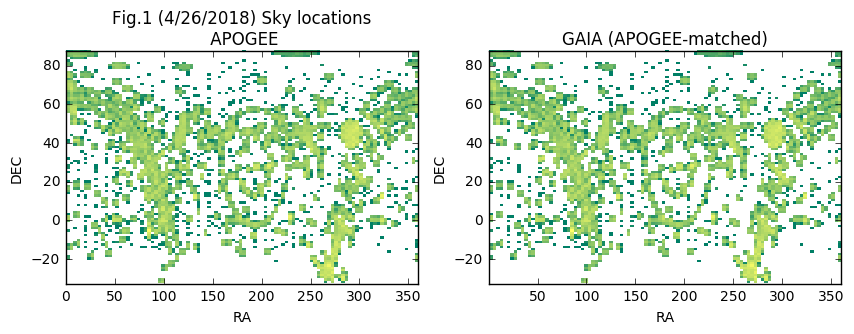

In [8]:
f, (ax1,ax2)=subplots(1,2,figsize=(10,3))
ax1.hist2d(ra_apo, dec_apo, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)
ax2.hist2d(ra_gaia, dec_gaia, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
ax1.set_title('Fig.1 (4/26/2018) Sky locations\n APOGEE')
ax2.set_title('GAIA (APOGEE-matched)')
show()

In [157]:
############### long computation, match GAIA-APOGEE
run = 1 ## to prevent myself pressing this cell

sphere2cart = lambda ra, dec: (cos(radians(ra))*cos(radians(dec)),
                               sin(radians((ra)))*cos(radians(dec)),
                               cos(radians(dec)))
if run:
    from scipy.spatial import KDTree
    x_apo, y_apo, z_apo = sphere2cart(ra_apo, dec_apo)
    print 'coordinate transformed apogee'
    tree_apo = KDTree(zip(x_apo, y_apo, z_apo))
    print 'tree built'
    x_gaia, y_gaia, z_gaia = sphere2cart(ra_gaia, dec_gaia)
    print 'coordinate transformed gaia'
    #tree_gaia = KDTree(zip(ra_gaia, dec_gaia))
    d_nearest, idx_nearest = tree_apo.query(zip(x_gaia, y_gaia, z_gaia))

coordinate transformed apogee
tree built
coordinate transformed gaia


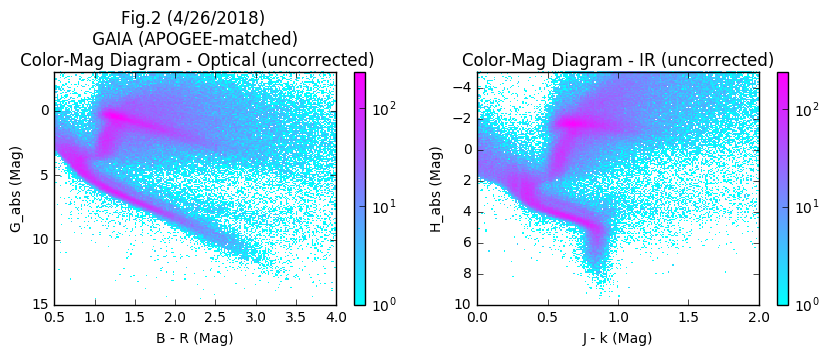

In [75]:
f, (ax1,ax2)=subplots(1,2,figsize=(10,3))
cs1=ax1.hist2d(Babs-Rabs, Gabs, bins=200, range = ((0.5,4),(-3, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
ax1.set_xlabel('B - R (Mag)')
ax1.set_ylabel('G_abs (Mag)')
ax1.invert_yaxis()
ax1.set_title('Fig.2 (4/26/2018) \n GAIA (APOGEE-matched) \n Color-Mag Diagram - Optical (uncorrected)')
f.colorbar(cs1[3], ax=ax1)

cs2=ax2.hist2d(Jabs-Kabs, Habs,  bins=200, range = ((0, 2),(-5, 10)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
ax2.set_xlabel('J - k (Mag)')
ax2.set_ylabel('H_abs (Mag)')
ax2.invert_yaxis()
f.colorbar(cs2[3], ax=ax2)
ax2.set_title('Color-Mag Diagram - IR (uncorrected)')
show()

In [76]:
print 'APOGEE object with GAIA match:',len(unique(idx_nearest))
print 'APOGEE object total:',len(ra_apo)
print 'GAIA objects with APOGEE match:', len(ra_gaia)
print 'GAIA objects with multiples (to APO):',len(ra_gaia)-len(unique(idx_nearest))

APOGEE object with GAIA match: 252335
APOGEE object total: 277371
GAIA objects with APOGEE match: 284394
GAIA objects with multiples (to APO): 32059


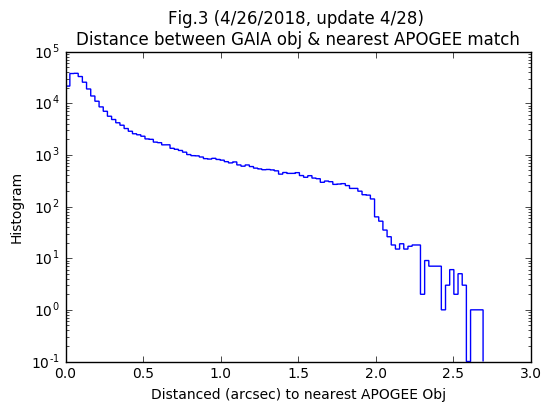

In [158]:
f, ax = subplots(1,1,figsize=(6,4))
ax.hist(degrees(d_nearest)*3600, bins=100,log=1,histtype='step')
ax.set_title('Fig.3 (4/26/2018, update 4/28) \nDistance between GAIA obj & nearest APOGEE match')
ax.set_xlabel('Distanced (arcsec) to nearest APOGEE Obj')
ax.set_ylabel('Histogram')
show()

In [78]:
############ look at RV_FWHM, MAG_ABS plane, after removing tellurics
cut_telluric =logical_not (hdulist[1].data['APOGEE_TARGET2'][idx_nearest] & 2**9)
cut_logg     =(hdulist[1].data['LOGG'][idx_nearest]<3.8) & (hdulist[1].data['LOGG'][idx_nearest]>-10)
cut_teff     =(hdulist[1].data['TEFF'][idx_nearest]<5000) 
#cut_JK       =(hdulist[1].data['J'][idx_nearest]-hdulist[1].data['K'][idx_nearest] > 0.5)
classes = hdulist[1].data['ASPCAP_CLASS'][idx_nearest]
cut_class    =(classes=='GKg_a')+(classes=='GKg_b')+(classes=='GKg_c')+(classes=='GKg_d')

In [19]:
RV = hdulist[1].data['RV_CCFWHM'][idx_nearest]

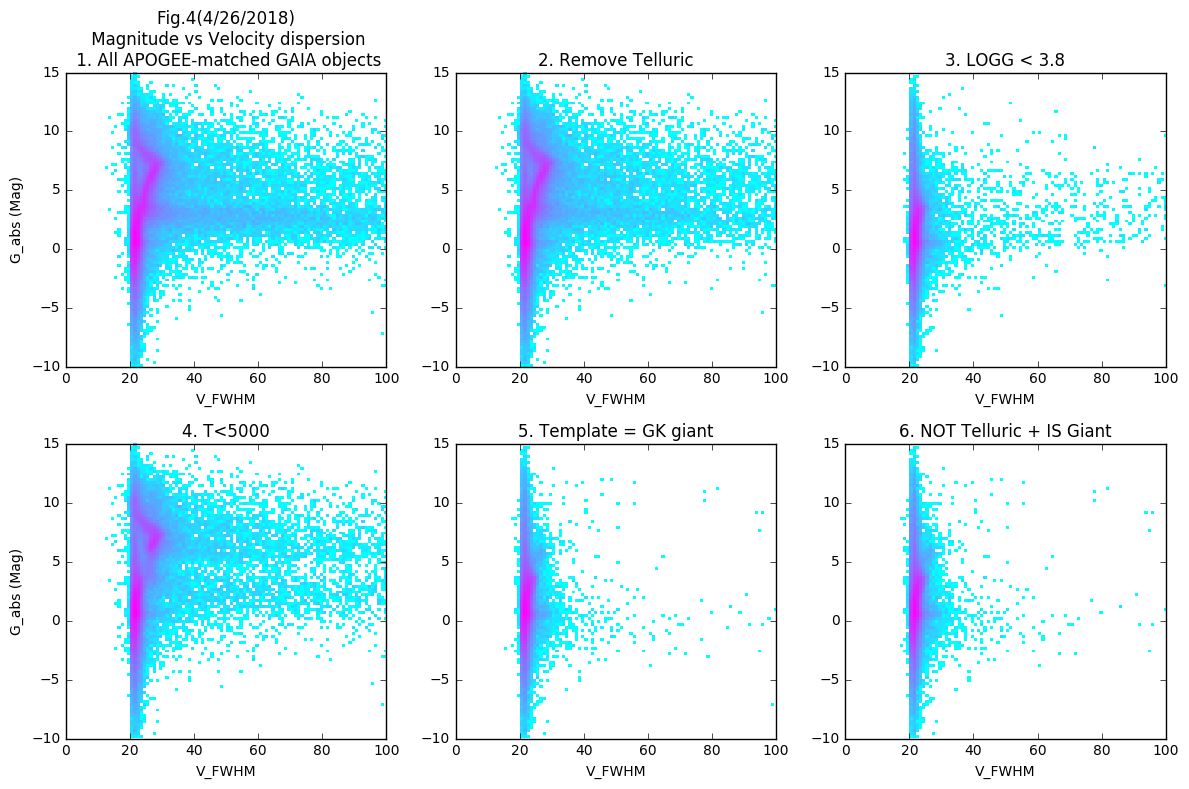

In [134]:
labels_arr = ['ALL','Remove Telluric', 'LOGG < 3.8', 'T<5000', 
              'Template = GK giant', 'NOT Telluric + IS Giant']
f, axes = subplots(2,3,figsize=(12,8))
axes=axes.flatten()

#colorbar(CB)
i=0
for icut in [1, cut_telluric, cut_logg, cut_teff, cut_class, cut_telluric*cut_class]:
    axes[i].set_title(str(i+1)+'. '+labels_arr[i], fontsize=12)
    axes[i].set_xlabel('V_FWHM')
    if i in [0,3]: axes[i].set_ylabel('G_abs (Mag)')
    if i==0:
        cs=axes[i].hist2d(RV, Gabs, bins=100, range=((0,100),(-10, 15)),
                       norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    else:
        cs=axes[i].hist2d(RV[where(icut)], Gabs[where(icut)], bins=100, range=((0,100),(-10, 15))
                      ,norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    #f.colorbar(cs[3], ax=axes[i])
    i+=1
axes[0].set_title('Fig.4(4/26/2018)\n Magnitude vs Velocity dispersion\n 1. All APOGEE-matched GAIA objects', fontsize=12)
plt.tight_layout()
show()

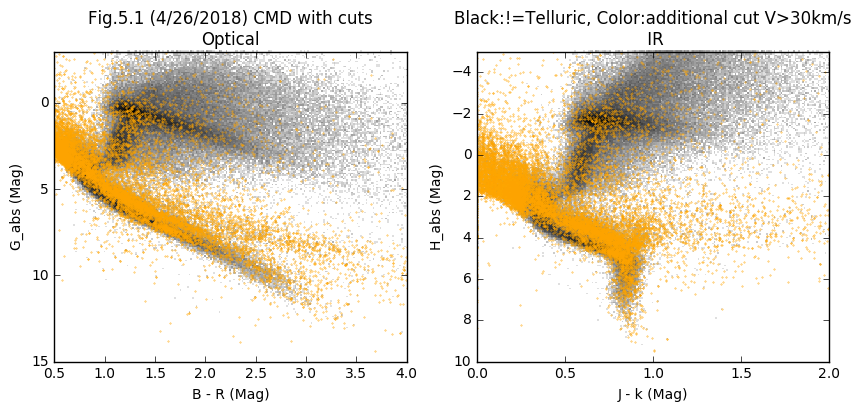

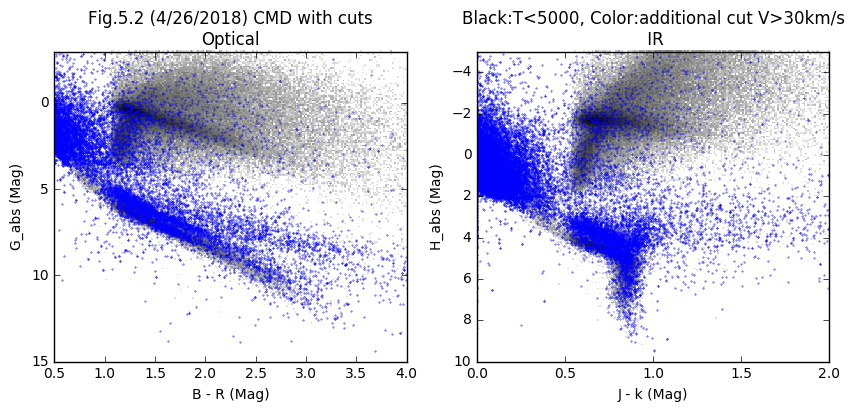

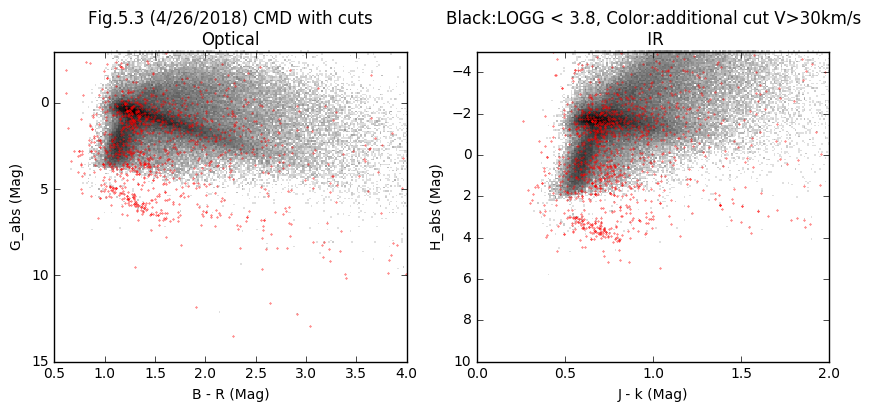

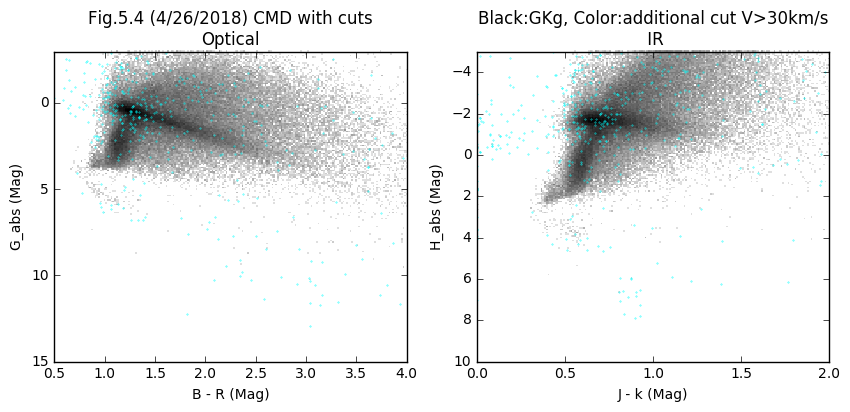

In [21]:
colors = ['orange','blue','red','cyan']
labels = ['!=Telluric', 'T<5000', 'LOGG < 3.8','GKg']
i=0
seed(5)
for icut in [cut_telluric, cut_teff, cut_logg, cut_class]:

    f, (ax1,ax2)=subplots(1,2,figsize=(10,4))
    ax1.hist2d( (Babs-Rabs)[icut], Gabs[icut], bins=200, range = ((0.5,4),(-3, 15)),
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)
    ax2.hist2d((Jabs-Kabs)[icut], Habs[icut],  bins=200, range = ((0, 2),(-5, 10)),
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)

    icolor=colors[i]#rand(3)
    iidx = where((RV>30.0)*icut)
    ax1.scatter((Babs-Rabs)[iidx],Gabs[iidx], c=icolor, edgecolors='face',s=0.1,label=labels[i])
    ax2.scatter((Jabs-Kabs)[iidx],Habs[iidx], c=icolor, edgecolors='face',s=0.1,label=labels[i])
    ax1.set_xlabel('B - R (Mag)')
    ax1.set_ylabel('G_abs (Mag)')
    ax1.invert_yaxis()

    ax1.set_title('Fig.5.%i (4/26/2018) CMD with cuts\nOptical'%(i+1))
    #ax1.legend(loc=3, frameon=1, fontsize=8)

    ax2.set_xlabel('J - k (Mag)')
    ax2.set_ylabel('H_abs (Mag)')
    ax2.invert_yaxis()
    ax2.set_title('Black:%s, Color:additional cut V>30km/s\n IR'%(labels[i]))
    i+=1

    show()

In [38]:
payne_data = loadtxt('Apogee_The_Payne_relaxed.txt', usecols=range(1,24)).T
#APOGEE_ID RA[deg] Dec[deg] Teff[K] Logg vmic[km/s] CH NH OH MgH AlH SiH SH KH CaH TiH CrH MnH FeH NiH CuH C12C13 22:vmac[km/s] 23:chi2_R 24:quality_flag

payne_apoid, pane_fit = loadtxt('Apogee_The_Payne_relaxed.txt', usecols=(0,24), dtype='string').T
matchedpayne = intersect1d(payne_apoid, hdulist[1].data['APOGEE_ID'], assume_unique=0)
matchedpaynegaia = intersect1d(payne_apoid, hdulist[1].data['APOGEE_ID'][idx_nearest], assume_unique=0)


In [41]:
print 'Num of unique/total Payne objects:',len(unique(payne_apoid)),len(payne_apoid)
print 'Num of unique/total APOGEE objects:',len(unique(hdulist[1].data['APOGEE_ID'])),len(hdulist[1].data['APOGEE_ID'])
print 'Num of GAIA objects:',len(idx_nearest)
print 'Num of Payne-APOGEE matched unique objects:',len(matchedpayne)
print 'Num of unique APOGEE-GAIA match:',len(unique(idx_nearest))
print 'Num of unique Payne-GAIA match:',len(unique(matchedpaynegaia) )

Num of unique/total Payne objects: 251450 270346
Num of unique/total APOGEE objects: 258475 277371
Num of GAIA objects: 284394
Num of Payne-APOGEE matched unique objects: 251449
Num of unique APOGEE-GAIA match: 252335
Num of unique Payne-GAIA match: 245468


In [92]:
########## use 3d dust map to correct for extinction/redenning
run_dust_correction = 0

if run_dust_correction:
    from dustmaps.bayestar import BayestarQuery 
    #from dustmaps.planck import PlanckQuery
    #from dustmaps.sfd import SFDQuery
    ## fetch maps: 4.3G
    ## dustmaps.bayestar.fetch()
    sfd = SFDQuery()
    bayestar = BayestarQuery(max_samples=2, version='bayestar2017')
    coords3d = SkyCoord(ra_gaia*units.deg, dec_gaia*units.deg,
                      distance=d_gaia*units.kpc, frame='icrs')
    ebv1 = sfd(coords3d)
    ebv2 = bayestar(coords3d, mode='median')

/Users/jia/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 12917 results
  RuntimeWarning)


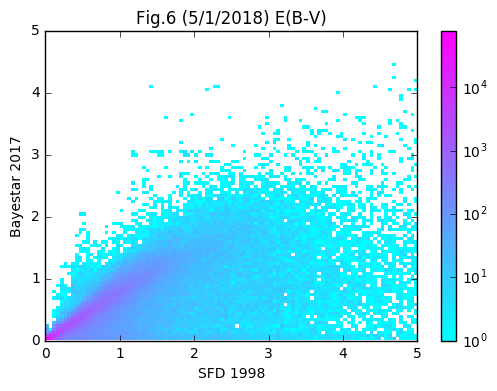

In [107]:
ebv1[isnan(ebv1)]=-99
ebv2[isnan(ebv2)]=-99

f, ax = subplots(1,1,figsize=(6,4))
cs=ax.hist2d(ebv1,ebv2,bins=100,range=((0,5),(0,5)),norm=mpl.colors.LogNorm(),cmap=mpl.cm.cool)
f.colorbar(cs[3], ax=ax)
ax.set_xlabel('SFD 1998')
ax.set_ylabel('Bayestar 2017')
ax.set_title('Fig.6 (5/1/2018) E(B-V)')
show()

In [159]:
### correct color
##  http://argonaut.skymaps.info/usage
## Table6 of SF2011: Ab/E(B−V)_SFD, Rv=3.1, B,G,R =2.976,1.850,1.452
## J,H,K =0.650, 0.327, 0.161
## Ab=ebv*[2.755,1.948,1.549]
Bcorr, Gcorr, Rcorr, Jcorr, Hcorr, Kcorr =  array([Babs, Gabs, Rabs, Jabs, Habs, Kabs])-(ebv2.reshape(1,-1)*array([2.755,1.948,1.549,0.650, 0.327, 0.161]).reshape(-1,1))

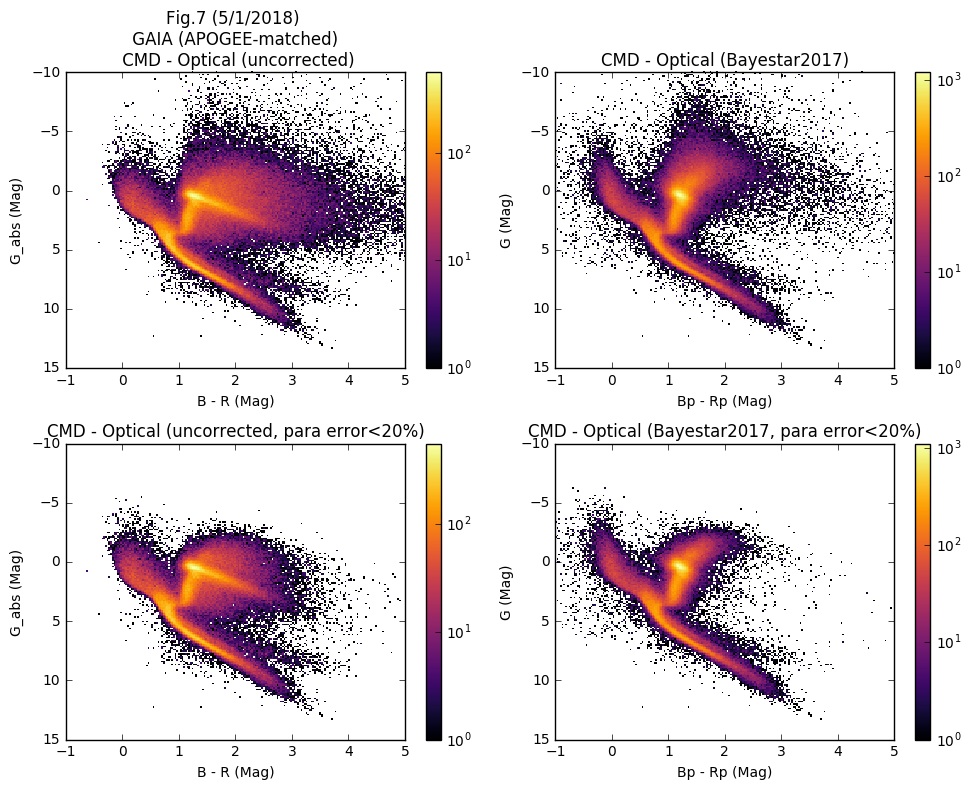

In [171]:
idx_optical = ( (Gabs!=-9999) & (Babs!=-9999) & (Gabs!=-9999) & (gaia('phot_g_mean_mag')<17)) # &idx_good_para
#idx_IR = ( (Jabs!=-9999) & (Habs!=-9999) & (Kabs!=-9999) & (Jabs!=Kabs))

f, ((ax1,ax2),(ax1b,ax2b))=subplots(2,2,figsize=(10,8))

cs1=ax1.hist2d( (Babs-Rabs)[idx_optical], Gabs[idx_optical], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax1.set_xlabel('B - R (Mag)')
ax1.set_ylabel('G_abs (Mag)')
ax1.invert_yaxis()
ax1.set_title('Fig.7 (5/1/2018) \n GAIA (APOGEE-matched) \n CMD - Optical (uncorrected)')
f.colorbar(cs1[3], ax=ax1)

cs1b=ax1b.hist2d( (Babs-Rabs)[idx_optical&idx_good_para], Gabs[idx_optical&idx_good_para], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax1b.set_xlabel('B - R (Mag)')
ax1b.set_ylabel('G_abs (Mag)')
ax1b.invert_yaxis()
ax1b.set_title('CMD - Optical (uncorrected, para error<20%)')
f.colorbar(cs1b[3], ax=ax1b)

cs2=ax2.hist2d( (Bcorr-Rcorr)[idx_optical], Gcorr[idx_optical], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax2.set_xlabel('Bp - Rp (Mag)')
ax2.set_ylabel('G (Mag)')
ax2.invert_yaxis()
ax2.set_title('CMD - Optical (Bayestar2017)')
f.colorbar(cs2[3], ax=ax2)

cs2b=ax2b.hist2d( (Bcorr-Rcorr)[idx_optical&idx_good_para], Gcorr[idx_optical&idx_good_para], bins=200, range = ((-1,5),(-10, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
ax2b.set_xlabel('Bp - Rp (Mag)')
ax2b.set_ylabel('G (Mag)')
ax2b.invert_yaxis()
ax2b.set_title('CMD - Optical (Bayestar2017, para error<20%)')
f.colorbar(cs2b[3], ax=ax2b)

plt.tight_layout()
show()

In [131]:
Image(url= "gaia_fig19.jpg")

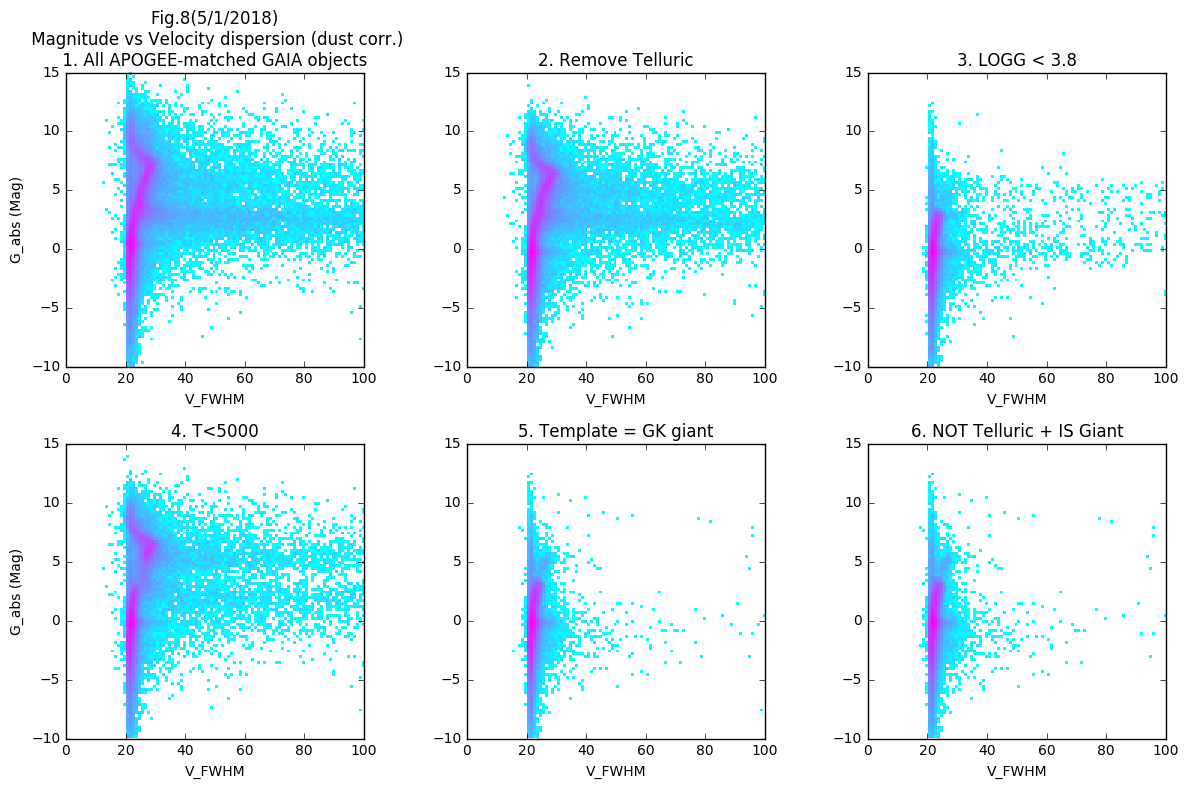

In [172]:
f, axes = subplots(2,3,figsize=(12,8))
axes=axes.flatten()

#colorbar(CB)
i=0
for icut in [1, cut_telluric, cut_logg, cut_teff, cut_class, cut_telluric*cut_class]:
    axes[i].set_title(str(i+1)+'. '+labels_arr[i], fontsize=12)
    axes[i].set_xlabel('V_FWHM')
    if i in [0,3]: axes[i].set_ylabel('G_abs (Mag)')
    if i==0:
        cs=axes[i].hist2d(RV, Gcorr, bins=100, range=((0,100),(-10, 15)),
                       norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    else:
        cs=axes[i].hist2d(RV[where(icut)], Rcorr[where(icut)], bins=100, range=((0,100),(-10, 15))
                      ,norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    #f.colorbar(cs[3], ax=axes[i])
    i+=1
axes[0].set_title('Fig.8(5/1/2018)\n Magnitude vs Velocity dispersion (dust corr.)\n 1. All APOGEE-matched GAIA objects ', fontsize=12)
plt.tight_layout()
show()